In [1]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")
import arviz as az
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Wir lesen den Datensatz `students.csv` ein und betrachten die ersten Zeilen des Dataframes.

In [2]:
data = pd.read_csv("./Daten/students.csv")
data.head()

,stud.id,name,gender,age,height,weight,religion,nc.score,semester,major,minor,score1,score2,online.tutorial,graduated,salary
1,833917,"Gonzales, Christina",Female,19,160,64.8,Muslim,1.91,1st,Political Science,Social Sciences,NaN,NaN,0,0,NaN
2,898539,"Lozano, T'Hani",Female,19,172,73.0,Other,1.56,2nd,Social Sciences,Mathematics and Statistics,NaN,NaN,0,0,NaN
3,379678,"Williams, Hanh",Female,22,168,70.6,Protestant,1.24,3rd,Social Sciences,Mathematics and Statistics,45.0,46.0,0,0,NaN
4,807564,"Nem, Denzel",Male,19,183,79.7,Other,1.37,2nd,Environmental Sciences,Mathematics and Statistics,NaN,NaN,0,0,NaN
5,383291,"Powell, Heather",Female,21,175,71.4,Catholic,1.46,1st,Environmental Sciences,Mathematics and Statistics,NaN,NaN,0,0,NaN


In [3]:
data.columns

Index(['stud.id', 'name', 'gender', 'age', 'height', 'weight', 'religion',
       'nc.score', 'semester', 'major', 'minor', 'score1', 'score2',
       'online.tutorial', 'graduated', 'salary'],
      dtype='object')

In [4]:
female_height = data[data["gender"]== "Female"]["height"][0:50]
female_height.head()

1    160
2    172
3    168
5    175
7    156
Name: height, dtype: int64

Wir betrachten also die Körpergrösse von Frauen, von welcher wir annehmen, dass diese normalverteilt ist. Zur Ueberprüfung dieser Annahme wollen wir den Q-Q-Plot der Körpergrösse der Studentinnen im Datensatz erstellen.

Text(0.5, 1.0, 'Grösse Frauen')

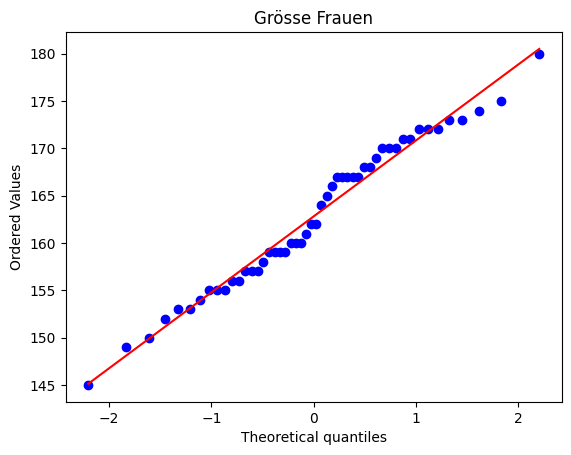

In [5]:
st.probplot(female_height,plot=plt)
plt.title("Grösse Frauen")
#plt.savefig('qq_students.png', dpi=300)

Aufgrund des QQ-Plots schliessen wir, dass die Körpergrösse von Frauen normalverteilt ist. Wir bezeichnen mit $ X $ die Körpergrösse einer zufällig ausgewählten Studentin, wobei
$$
X
\sim \mathcal{N}(\mu, \sigma^{2})
$$


Wir wollen nun eine Aussage über $ \mu $ treffen. Zunächst gehen wir davon aus, dass $ \sigma $ bekannt ist, sagen wir $ \sigma=10 $. 

Es stellt sich nun die Frage, wie wir die Prior-Verteilung für $ \mu $ wählen. Eine 
Beta-Verteilung ist für diese Situation nicht passend, da deren Parameterwerte $ \theta $ nur Werte
von $ 0 $ bis $ 1 $ annimmt. Viele Verteilungen sind in diesem Fall denkbar. Wir gehen der Einfachheit halber vorläufig von einer gleichförmigen Verteilung aus. Wir gehen hier von grossem Unwissen aus, nämlich dass $ \mu $ zwischen 100 und 250cm liegen kann , d.h. alle Werte in diesem Bereich können mit der gleichen 'Wahrscheinlichkeit' vorkommen. Natürlich könnten wir hier mehr Vorwissen einfliessen lassen, was wir später auch machen werden.

Als Likelihood-Funktion wählen wir eine Normalverteilungsfunktion mit dem Datensatz `female_height`, der aus 50 Messungen der Körpergrösse von Frauen besteht. Falls $ \sigma=10 $ und $ x=\{x_{1},x_{2},\dots,x_{50} \} =\{160,\ldots, 155\}$, so lautet die Likelihood-Funktion
\begin{align*}
p(x | \mu,\sigma)
&=\dfrac{1}{\sigma\sqrt{2\pi}}\cdot\exp{\left(-\frac{(x_{1}-\mu)^2}{2\sigma^2}\right)}\cdot\ldots\cdot \dfrac{1}{\sigma\sqrt{2\pi}}\cdot\exp{\left(-\frac{(x_{50}-\mu)^2}{2\sigma^2}\right)}\\
&=\dfrac{1}{10\sqrt{2\pi}}\cdot\exp{\left(-\frac{(160-\mu)^2}{2\cdot 100}\right)}\cdot\ldots\cdot \dfrac{1}{10\sqrt{2\pi}}\cdot\exp{\left(-\frac{(155-\mu)^2}{2\cdot 100}\right)}\\
\end{align*}

Diese Likelihood-Funktion betrachten wir nun als abhängig von $ \mu $ und können nun zusammen mit der Prior-Verteilung die Posterior-Verteilung bestimmen. Dies machen wir nun natürlich mit `pymc3`.

Der Input ist sehr ähnlich wie beim Beta-Prior, aber wir müssen hier 2 Parameter spezifizieren, nämlich $ \mu $ und $ \sigma $, da die Likelihood-Funktion von zwei Parametern abhängig ist. Wir wollen zunächst nur einen Parameter, nämlich $ \mu $, mit MCMC bestimmen.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


<Axes: title={'center': 'μ'}>

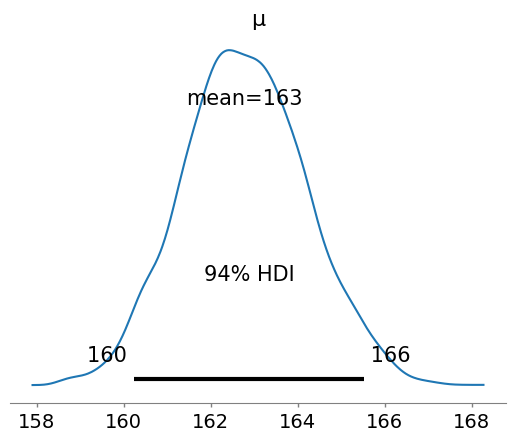

In [7]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=100, upper=250)
    σ = 10 
    y = pm.Normal('y', mu=μ, sigma=σ, observed=female_height)
    trace_g = pm.sample()
    
az.plot_posterior(trace_g)

Wir stellen also fest, dass der Mittelwert der Posterior-Verteilung bei 163cm liegt und dass 94\% der wahrscheinlichsten $ \mu $'s im Bereich von 160 bis 165cm liegen.


Nehmen wir an,  eine Zeitung schreibt, dass die durchschnittliche Körpergrösse von Frauen in der Schweiz bei 175cm liegt. Passt diese Angabe zu unseren Daten und zu unserer Prior-Verteilung? 

Männer sind durchschnittlich eher grösser als Frauen. Aber ist dieser Unterschied auch statistisch relevant? Dazu wählen wir 65 Studenten aus und führen dieselbe Untersuchung durch. Wir stellen fest, dass die Körpergrösse dieser 65 Studenten annähernd einer  Normalverteilung folgt. 

In [8]:
male_height = data[data["gender"]== "Male"]["height"][0:65]

Die Berechnung der Posterior-Verteilung der Körpergrösse von Studenten einerseits und die Berechnung der Posterior-Verteilung Körpergrösse von Studentinnen andererseits kann mittels `pymc3`
beides in einem Schritt durchgeführt werden. 
 
Dazu müssen wir aber zwei $ \mu$'s spezifizieren, $ \mu_{1} $ für die Frauen und $ \mu_{2} $ für die Männer. In Abbildung unten sehen wir die beiden Posterior-Plots.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_1, μ_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([<Axes: title={'center': 'μ_1'}>, <Axes: title={'center': 'μ_2'}>],
      dtype=object)

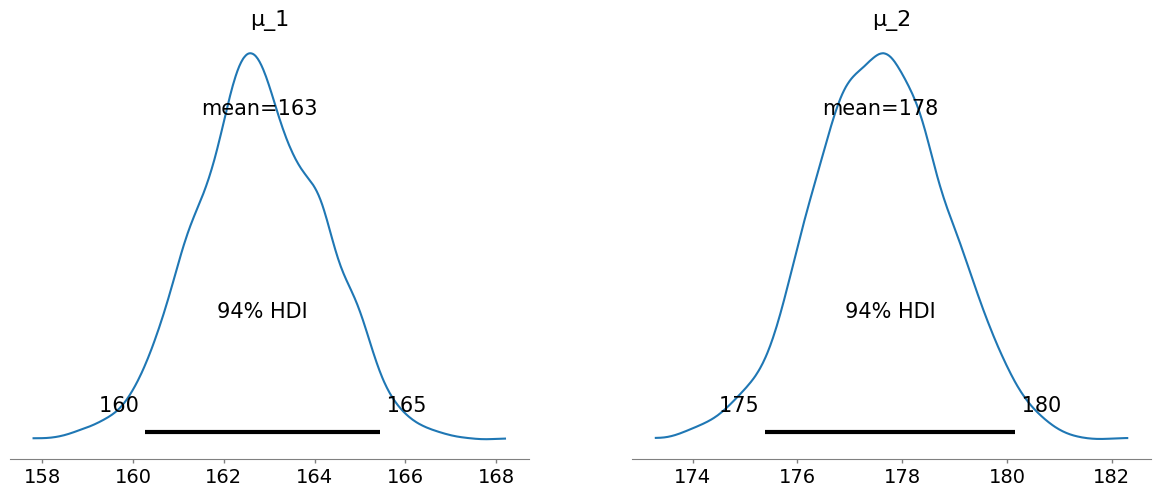

In [9]:
with pm.Model() as model_mul:
    μ_1 = pm.Uniform('μ_1', lower=100, upper=250)
    μ_2 = pm.Uniform('μ_2', lower=100, upper=250)
    σ = 10 
    y_f = pm.Normal('y_f', mu=μ_1, sigma=σ, observed=female_height)
    y_m = pm.Normal('y_m', mu=μ_2, sigma=σ, observed=male_height)
    trace_mul = pm.sample(1000)

az.plot_posterior(trace_mul)

Der 94\%-HDI von $ \mu_{1} $ ist $ [160,165] $ und für $ \mu_{2} $ ist es $ [175,180] $. Das heisst, die wahrscheinlichsten Werte für $ \mu_{1} $ und $ \mu_{2} $ überschneiden sich nicht. Wir ziehen daraus den Schluss, dass Männer statistisch relevant grösser sind als Frauen.  